# Template for evaluating performance, getting predictions for upcoming fights

Copy me for quick experiments

In [1]:
import sys
sys.path.append('/Users/john/play/sports/') # add parent directory to path

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from db import base_db_interface

df = base_db_interface.read("bfo_espn_ufc_features")
for dt_col in ["Date", "DOB", "DOB_opp"]:
    df[dt_col] = pd.to_datetime(df[dt_col])
df[["FighterOpen", "OpponentOpen"]] = df[["FighterOpen", "OpponentOpen"]]\
    .astype(float)

# for slightly faster debugging, only use a subset of the data
sample_fighter_ids = df["FighterID_espn"].sample(500).values
df = df[df["FighterID_espn"].isin(sample_fighter_ids) | df["OpponentID_espn"].isin(sample_fighter_ids)]

# each fight has two rows, one for each (FighterID, OpponentID) permutation
df = df.drop_duplicates(subset=["FighterID_espn", "OpponentID_espn", "fight_id"])
df["FighterID_espn"] = df["FighterID_espn"].fillna("unknown")
df["OpponentID_espn"] = df["OpponentID_espn"].fillna("unknown")
print(df.shape)
df.head() # show the first 5 rows

(15114, 249)


,fight_id,Date,FighterResult,Decision,Rnd,Time,Event,OpponentID_espn,FighterID_espn,TSL,...,prev_weight,FighterID_espn_opp,n_career_fights_opp,n_ufc_fights_opp,t_since_first_fight_opp,t_since_prev_fight_opp,total_ufc_cage_time_opp,min_weight_opp,max_weight_opp,prev_weight_opp
87,1994-12-16_2335726_2951151,1994-12-16,W,Submission,1,0:52,UFC 4: Revenge of the Warriors,2951151,2335726,0.0,...,NaN,2951151,1,2,0,0.0,295.0,NaN,NaN,NaN
93,1994-12-16_2335646_2952788,1994-12-16,W,KO/TKO,1,2:13,UFC 4: Revenge of the Warriors,2952788,2335646,23.0,...,NaN,2952788,0,1,0,NaN,0.0,NaN,NaN,NaN
94,1994-12-16_2335697_2335726,1994-12-16,L,Submission,1,15:49,UFC 4: Revenge of the Warriors,2335697,2335726,27.0,...,NaN,2335697,9,10,399,0.0,1454.0,265.0,265.0,265.0
96,1994-12-16_2335726_2500342,1994-12-16,L,Submission,1,1:45,UFC 4: Revenge of the Warriors,2335726,2500342,12.0,...,NaN,2335726,2,3,0,0.0,1001.0,NaN,NaN,NaN
97,1994-12-16_2335697_2335726,1994-12-16,W,Submission,1,15:49,UFC 4: Revenge of the Warriors,2335726,2335697,80.0,...,265.0,2335726,1,2,0,0.0,52.0,NaN,NaN,NaN


In [3]:
df["FighterID_espn"].nunique()

5751

In [4]:
df["fight_id"].value_counts().value_counts()

2    7557
Name: fight_id, dtype: int64

In [5]:
df["win_target"] = df["FighterResult"].replace({"W":1, "L":0, "D":np.nan})
df["win_target"].value_counts(dropna=False)

1.0    7379
0.0    7379
NaN     356
Name: win_target, dtype: int64

In [6]:
# have to parse the decision column to get the detailed result
def parse_decision(s):
    if (s.startswith("submission") or 
        s.startswith("sumission") or
        s.startswith("technical submission")
    ):
        return "submission"
    if (s.startswith("tko") or 
        s.startswith("ko") or
        (s == 'could not continue')
    ):
        return "tko_ko"
    if "decision" in s:
        return "decision"
    return "other"

temp_decision = df["Decision"].fillna("-").str.lower().str.strip()
decision_clean = temp_decision.apply(parse_decision)
result_sign = df["FighterResult"].map({"W": 1, "L":-1, "D": 0})
decision_score = decision_clean.map({"tko_ko":2, "submission":2, 
                                                    "decision":1, "other":0})
df["ordinal_fighter_result"] = result_sign * decision_score
submission_score = decision_clean.map({"submission":1, "decision":0, 
                                            "other":0, "tko_ko":0})
tko_ko_score = decision_clean.map({"submission":0, "decision":0, 
                                            "other":0, "tko_ko":1})
decision_score = decision_clean.map({"submission":0, "decision":1, 
                                            "other":0, "tko_ko":0})
finish_score = decision_clean.map({"submission":1, "decision":0, 
                                            "other":0, "tko_ko":1})
df["submission_fighter_result"] = result_sign * submission_score
df["tko_ko_fighter_result"] = result_sign * tko_ko_score
df["decision_fighter_result"] = result_sign * decision_score
df["finish_fighter_result"] = result_sign * finish_score

df["win_target_finish"] = df["win_target"] * decision_clean.map({
    "submission":1, "tko_ko":1,
    "decision":np.nan, "other":np.nan, 
})
df["win_target_finish"].value_counts(dropna=False)

NaN    5358
1.0    4878
0.0    4878
Name: win_target_finish, dtype: int64

In [16]:
df.dropna(subset=["win_target_finish"])["fight_id"]

87        1994-12-16_2335726_2951151
93        1994-12-16_2335646_2952788
94        1994-12-16_2335697_2335726
96        1994-12-16_2335726_2500342
97        1994-12-16_2335697_2335726
                     ...            
132507    2023-03-11_2976026_3895544
132545    2023-03-18_3153250_4705600
132565    2023-03-18_3153250_4705600
132576    2023-03-24_5078113_5134372
132591    2023-03-24_5078113_5134372
Name: fight_id, Length: 9756, dtype: object

In [18]:
df.query("fight_id == '2023-03-24_5078113_5134372'")[["win_target", "win_target_finish", "test_target"]]

,win_target,win_target_finish,test_target
132576,1.0,1.0,1.0
132591,0.0,0.0,-1.0


In [7]:
def parse_fight_time(row):
    if not np.isnan(row["time_dur"]):
        return row["time_dur"]
    if row["Rnd"] == "-":
        return np.nan
    if row["Time"] == "-":
        # assuming 5 minute rounds
        # fill in something for now
        return int(row["Rnd"]) * 5 * 60
    n_rounds = row["Rnd"].strip()
    min, sec = row["Time"].strip().split(":")
    if n_rounds == "-":
        return np.nan
    n_rounds = int(n_rounds) - 1
    if (min == "-") | (sec == "-"):
        return np.nan
    min = int(min)
    sec = int(sec)
    # assuming 5 minute rounds
    return (n_rounds * 5 * 60) + min * 60 + sec
    
df["Rnd"] = df["Rnd"].fillna("-")
df["Time"] = df["Time"].fillna("-")
df["fight_time"] = df.apply(parse_fight_time, axis=1)
df["fight_time"].notnull().mean()

0.9779012835781394

In [8]:
def parse_fight_time(row):
    if not np.isnan(row["time_dur"]):
        return row["time_dur"]
    if row["Rnd"] == "-":
        return np.nan
    if row["Time"] == "-":
        # assuming 5 minute rounds
        # fill in something for now
        return int(row["Rnd"]) * 5 * 60
    n_rounds = row["Rnd"].strip()
    min, sec = row["Time"].strip().split(":")
    if n_rounds == "-":
        return np.nan
    n_rounds = int(n_rounds) - 1
    if (min == "-") | (sec == "-"):
        return np.nan
    min = int(min)
    sec = int(sec)
    # assuming 5 minute rounds
    return (n_rounds * 5 * 60) + min * 60 + sec
    
df["Rnd"] = df["Rnd"].fillna("-")
df["Time"] = df["Time"].fillna("-")
df["fight_time"] = df.apply(parse_fight_time, axis=1)
df["fight_time"].notnull().mean()

0.9779012835781394

<AxesSubplot:>

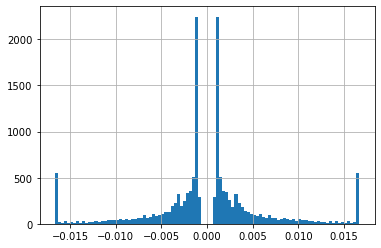

In [9]:
y = (-1)**df["win_target"]
# restrict btw 1 and 25 minutes (length of a title fight)
# short fight times -> big outliers
clipped_time_dur = df["fight_time"].clip(60, (5*5*60))
df["signed_inverse_fight_time"] = y / clipped_time_dur
df["signed_inverse_sqrt_fight_time"] = y / np.sqrt(clipped_time_dur)
df["signed_inverse_log_fight_time"] = y / np.log(clipped_time_dur)

df["signed_inverse_fight_time"].hist(bins=100)

# Attempting to rewrite the *EloEstimator classes

In [11]:
df["test_target"] = df["win_target_finish"] * 2 - 1
df["test_target"].value_counts(dropna=False)

 NaN    5358
 1.0    4878
-1.0    4878
Name: test_target, dtype: int64

100%|██████████| 4/4 [00:00<00:00, 398.75it/s]


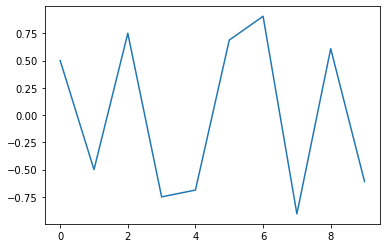

100%|██████████| 4/4 [00:00<00:00, 465.12it/s]


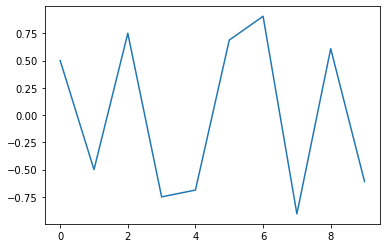

100%|██████████| 4/4 [00:00<00:00, 486.80it/s]


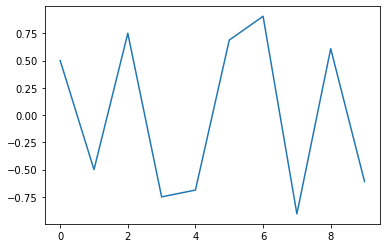

100%|██████████| 4/4 [00:00<00:00, 478.42it/s]


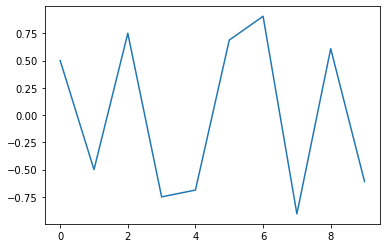

100%|██████████| 4/4 [00:00<00:00, 477.72it/s]


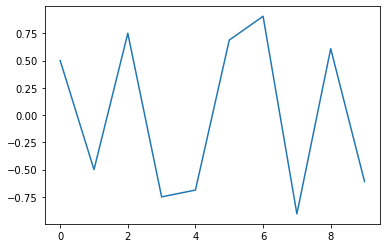

100%|██████████| 4/4 [00:00<00:00, 487.38it/s]


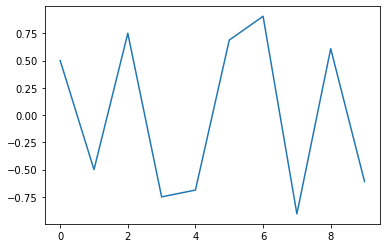

100%|██████████| 4/4 [00:00<00:00, 406.80it/s]


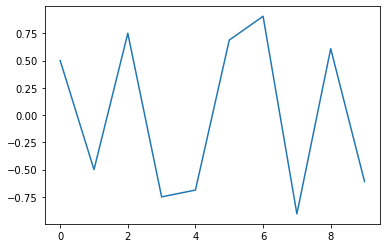

100%|██████████| 4/4 [00:00<00:00, 449.30it/s]


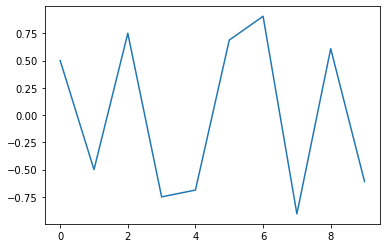

100%|██████████| 4/4 [00:00<00:00, 440.53it/s]


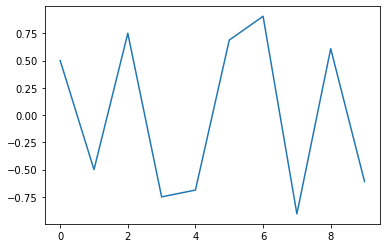

100%|██████████| 4/4 [00:00<00:00, 488.65it/s]


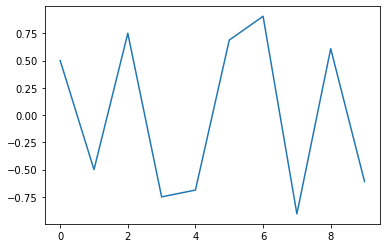

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm 
from sklearn.metrics import log_loss, accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from scipy.special import expit, logit
from abc import ABC, abstractmethod

unknown_fighter_id = "2557037" # "2557037/unknown-fighter"

class BaseEloEstimator(ABC):
    """
    Abstract Base class for Elo estimators.
    Requires a few methods to be implemented:
    - update_powers
    - predict_given_powers
    - fit_initial_params
    """

    def __init__(self, target_col, alpha=0.5):
        self.target_col = target_col
        self.alpha = alpha
        self.fighter_ids = None
        self.fighter_ids_with_target = None
        self.useless_fighter_ids = None
        self._fighter_encoder = None
        self._fighter_powers = None
        self.elo_feature_df = None
        # store the matrices for the fighter ids and opponent ids
        self.fighter_id_mat = None
        self.opponent_id_mat = None
        # debugging
        self.workhorse_df = None

    def transform_fighter_ids(self, fighter_ids:pd.Series):
        return self._fighter_encoder.transform(fighter_ids.values.reshape(-1,1))
    
    def fit_fighter_encoder(self, fighter_ids:pd.Series):
        self.fighter_ids = sorted(set(fighter_ids))
        self._fighter_encoder = OneHotEncoder(handle_unknown="error")
        self._fighter_encoder.fit(fighter_ids.values.reshape(-1,1))

    def fit_initial_params(self, df:pd.DataFrame):
        """
        Fit the initial parameters of the model, besides initializing the
        powers of the fighters in self._fighter_powers and the
        self._fighter_encoder.
        """
        raise NotImplementedError()
    
    def get_power_update(self, y_hat, y_true, df: pd.DataFrame):
        """
        Compute the power update for a batch of predictions.
        """
        raise NotImplementedError()
    
    def update_powers(self, df: pd.DataFrame):
        """
        Destructively update the powers of the fighters, given the observed target.
        Note that this is a "batch" update, i.e. it updates all the powers
        at once.
        Also, this is a "doubled" dataset, i.e. that each fight is
        represented twice, once for each (Fighter, Opponent) permutation.
        """
        raise NotImplementedError()
    
    def predict(self, df: pd.DataFrame):
        """
        Predict the target given the current powers of the fighters (stored 
        in self._fighter_powers). df may be used to
        extract additional features.
        """
        raise NotImplementedError()
    
    def predict_given_powers(self, fighter_powers, opponent_powers, df: pd.DataFrame):
        """
        Predict the target given the powers of the fighters. df may be used to
        extract additional features.
        """
        raise NotImplementedError()

    def fit(self, df:pd.DataFrame):
        """
        Assuming that the data is "doubled" - i.e. that each fight is
        represented twice, once for each (Fighter, Opponent) permutation.
        Returns a dataframe with the same number of rows as the input df.
        df: pd.DataFrame
        """
        assert (df["fight_id"].value_counts() == 2).all()
        df = df.sort_values(["fight_id", "FighterID_espn", "OpponentID_espn"]).reset_index(drop=True)
        if self.fighter_ids is None:
            self.fit_fighter_encoder(df["FighterID_espn"])
        self._fighter_powers = np.zeros(len(self.fighter_ids))
        # fit initial params, if any
        self.fit_initial_params(df)
        # apply the elo update rule to fit the powers over time
        target_df = df.dropna(subset=[self.target_col])
        fitted_elo_df = self._fit_workhorse(target_df)
        self.workhorse_df = fitted_elo_df
        # okay this is the tricky part - ffilling
        join_cols = ["fight_id", "FighterID_espn", "OpponentID_espn", "Date"]
        elo_df = df[join_cols].merge(
            fitted_elo_df, 
            on=join_cols,
            how="left"
        )
        self.elo_feature_df = self._fit_ffill(elo_df)
        return self.elo_feature_df
    
    def _fit_workhorse(self, target_df:pd.DataFrame):
        """ 
        This is the workhorse function that applies the elo update rule
        to the data. Assumes that there are no missing values in the target
        column, and that the data is doubled (i.e. each fight is represented twice)
        """
        # target_df = target_df.sort_values(["fight_id", "FighterID_espn", "OpponentID_espn"]).reset_index(drop=True)
        # 
        target_df = target_df.reset_index(drop=False)
        # transform the fighter ids into a (n_fights, n_fighters) matrix
        self.fighter_id_mat = self.transform_fighter_ids(target_df["FighterID_espn"])
        # transform the opponent ids into a (n_fights, n_fighters) matrix
        self.opponent_id_mat = self.transform_fighter_ids(target_df["OpponentID_espn"])
        # initialize predictions and powers over time to 0
        pred_elo_targets = np.zeros(len(target_df))
        fighter_powers_pre_update = np.zeros((len(target_df), len(self.fighter_ids)))
        fighter_powers_post_update = np.zeros((len(target_df), len(self.fighter_ids)))
        for dt, grp in tqdm(target_df.groupby(["Date"])):
            # pred_elo_targets is (len(grp),)
            pred_elo_targets[grp.index] = self.predict(grp)
            # store the powers over time
            fighter_powers_pre_update[grp.index] = self._fighter_powers
            # update the powers
            self.update_powers(grp)
            # store the powers over time
            fighter_powers_post_update[grp.index] = self._fighter_powers
        # store the powers over time in a dataframe
        fitted_elo_df = target_df[[
            "fight_id", "FighterID_espn", "OpponentID_espn", "Date",
            self.target_col, "index"
        ]].assign(
            pred_elo_target=pred_elo_targets,
            fighter_elo=np.diagonal(fighter_powers_pre_update * self.fighter_id_mat.T),
            opponent_elo=np.diagonal(fighter_powers_pre_update * self.opponent_id_mat.T),
            updated_fighter_elo=np.diagonal(fighter_powers_post_update * self.fighter_id_mat.T),
            updated_opponent_elo=np.diagonal(fighter_powers_post_update * self.opponent_id_mat.T),
        ).set_index("index")
        # return the dataframe
        return fitted_elo_df
            
    def _fit_ffill(self, elo_df:pd.DataFrame):
        """
        This is the function that forward-fill's fighter elo scores. If the target_col
        is missing, then we ffill the fighter's elo and opponent's elo from their
        previous fights, respectively.
        elo_df: pd.DataFrame, columns = [
            "fight_id", "FighterID_espn", "OpponentID_espn", "Date",
            self.target_col, 
            "pred_elo_target", "fighter_elo", "opponent_elo",
            "updated_fighter_elo", "updated_opponent_elo",
        ]
        fighter_elo, updated_fighter_elo, opponent_elo, updated_opponent_elo will be
        null if the target_col is missing.
        """
        # elo_df = elo_df.sort_values(["fight_id", "FighterID_espn", "OpponentID_espn"]).reset_index(drop=True)
        # # 0. initialize the elo scores to 0
        # first_elo_inds = elo_df.groupby(["FighterID_espn",]).first().index
        # elo_df.loc[first_elo_inds, "fighter_elo"] = 0
        # first_elo_inds = elo_df.groupby(["OpponentID_espn"]).first().index
        # elo_df.loc[first_elo_inds, "opponent_elo"] = 0
        # 1. ffill the elo scores with the updated elo scores because the updated elo scores
        # are the most recent. fighter_elo and opponent_elo from the previous fight will
        # not contain information about the outcome of the previous fight.
        elo_df["fighter_elo"] = elo_df.groupby("FighterID_espn")["updated_fighter_elo"].ffill()
        elo_df["opponent_elo"] = elo_df.groupby("OpponentID_espn")["updated_opponent_elo"].ffill()
        # 2. Any fights left with null fighter_elo or opponent_elo are fights where the
        # fighter never recorded the target statistic prior to the fight. We impute
        # their elo scores with 0
        elo_df["fighter_elo"] = elo_df["fighter_elo"].fillna(0)
        elo_df["opponent_elo"] = elo_df["opponent_elo"].fillna(0)
        # 3. Any fights left with null updated_fighter_elo or updated_opponent_elo are
        # fights where the fighter never recorded the target statistic in the fight.
        # We impute their updated elo scores with their elo scores from the previous fight
        elo_df["updated_fighter_elo"] = elo_df["updated_fighter_elo"].fillna(
            elo_df["fighter_elo"]
        )
        elo_df["updated_opponent_elo"] = elo_df["updated_opponent_elo"].fillna(
            elo_df["opponent_elo"]
        )
        # 4. Calculate pred_elo_target using the imputed elo scores
        elo_df["pred_elo_target"] = self.predict_given_powers(
            elo_df["fighter_elo"], elo_df["opponent_elo"]
        )
        # 5. Return the dataframe
        return elo_df


class RealEloEstimator(BaseEloEstimator):
    """ 
    Use this to estimate elo scores for real-valued, symmetric score differences.
    """

    def fit_initial_params(self, df: pd.DataFrame):
        # transform the fighter ids into a (n_fights, n_fighters) matrix
        self.fighter_id_mat = self.transform_fighter_ids(df["FighterID_espn"])
        # transform the opponent ids into a (n_fights, n_fighters) matrix
        self.opponent_id_mat = self.transform_fighter_ids(df["OpponentID_espn"])

    def predict(self, df: pd.DataFrame):
        # get current fighters (len(grp), n_fighters)
        # curr_fighter = self._fighter_encoder.transform(df["FighterID_espn"].values.reshape(-1, 1))
        # get current opponents (len(grp), n_fighters)
        # curr_opponent = self._fighter_encoder.transform(df["OpponentID_espn"].values.reshape(-1, 1))
        curr_fighter = self.fighter_id_mat[df.index]
        # # get current opponents (len(grp), n_fighters)
        curr_opponent = self.opponent_id_mat[df.index]
        # get the powers of the fighters (len(grp),)
        curr_fighter_powers = self._fighter_powers @ curr_fighter.T
        # get the powers of the opponents
        curr_opponent_powers = self._fighter_powers @ curr_opponent.T
        # get the predictions
        pred_elo_targets = curr_fighter_powers - curr_opponent_powers
        return pred_elo_targets
    
    def predict_given_powers(self, fighter_powers, opponent_powers):
        # get the predictions
        pred_elo_targets = fighter_powers - opponent_powers
        return pred_elo_targets
    
    def update_powers(self, df: pd.DataFrame):
        # get the predictions
        y_hat = self.predict(df)
        # get the targets
        y_true = df[self.target_col]
        delta = self.alpha * (y_true - y_hat)
        # get current fighters (len(grp), n_fighters)
        # curr_fighter = self._fighter_encoder.transform(df["FighterID_espn"].values.reshape(-1, 1))
        # get current opponents (len(grp), n_fighters)
        # curr_opponent = self._fighter_encoder.transform(df["OpponentID_espn"].values.reshape(-1, 1))
        # # get current fighters (len(grp), n_fighters)
        curr_fighter = self.fighter_id_mat[df.index]
        # # get current opponents (len(grp), n_fighters)
        curr_opponent = self.opponent_id_mat[df.index]
        # update the powers
        # the usual update rule is:
        # self._fighter_powers += 0.5 * (alpha * (y_true - y_hat)) * (curr_fighter - curr_opponent)
        # because df is "doubled", we need to divide by 2
        self._fighter_powers += 0.25 * np.array(delta) @ (curr_fighter - curr_opponent)

# picking this one because it's null much of the time
# easy_df = df.dropna(subset=["test_target"]).sort_values("Date").reset_index(drop=True)
from wrangle.join_datasets import get_fight_id

for _ in range(10):
    easy_df = pd.DataFrame([
        (1, 2, "2020-01-01", 1),
        (2, 1, "2020-01-01", -1),

        (1, 2, "2020-01-02", 1),
        (2, 1, "2020-01-02", -1),

        (3, 2, "2020-01-03", 1),
        (2, 3, "2020-01-03", -1),

        # missing test_target
        (1, 2, "2020-01-04", None),
        (2, 1, "2020-01-04", None),

        # non-null test_target
        (1, 3, "2020-01-05", 1),
        (3, 1, "2020-01-05", -1),

    ], columns=["FighterID_espn", "OpponentID_espn", "Date", "test_target"])
    easy_df = easy_df.sample(frac=1).reset_index(drop=True)
    # easy_df["Date"] = pd.to_datetime(easy_df["Date"])
    easy_df["FighterID_espn"] = easy_df["FighterID_espn"].astype(str)
    easy_df["OpponentID_espn"] = easy_df["OpponentID_espn"].astype(str)

    easy_df["fight_id"] = get_fight_id(easy_df["FighterID_espn"], easy_df["OpponentID_espn"], easy_df["Date"])

    elo_estimator = RealEloEstimator(target_col="test_target", alpha=0.5)
    elo_estimator.fit(easy_df)
    #display(elo_estimator.elo_feature_df.sort_values(["fight_id", "FighterID_espn", "OpponentID_espn"]))
    plt.plot(elo_estimator.elo_feature_df.sort_values(["fight_id", "FighterID_espn", "OpponentID_espn"])["pred_elo_target"].values)
    plt.show()

In [133]:
# from model.mma_elo_model import RealEloEstimator

# picking this one because it's null much of the time
elo_estimator = RealEloEstimator(target_col="test_target", alpha=0.5)
elo_estimator.fit(df.dropna(subset=["test_target"]).sort_values("Date").reset_index(drop=True))
elo_estimator.elo_feature_df

100%|██████████| 2300/2300 [00:04<00:00, 513.58it/s]


,fight_id,FighterID_espn,OpponentID_espn,Date,test_target,pred_elo_target,fighter_elo,opponent_elo,updated_fighter_elo,updated_opponent_elo
0,1994-12-16_2335646_2952788,2335646,2952788,1994-12-16,1.0,0.500000,0.250000,-0.250000,0.250000,-0.250000
1,1994-12-16_2335646_2952788,2952788,2335646,1994-12-16,-1.0,-0.500000,-0.250000,0.250000,-0.250000,0.250000
2,1994-12-16_2335653_2473329,2335653,2473329,1994-12-16,1.0,0.500000,0.250000,-0.250000,0.250000,-0.250000
3,1994-12-16_2335653_2473329,2473329,2335653,1994-12-16,-1.0,-0.500000,-0.250000,0.250000,-0.250000,0.250000
4,1994-12-16_2335697_2335726,2335697,2335726,1994-12-16,1.0,0.000000,0.250000,0.250000,0.250000,0.250000
...,...,...,...,...,...,...,...,...,...,...
9751,2023-03-11_2993650_4421473,4421473,2993650,2023-03-11,-1.0,-0.244532,0.522991,0.767523,0.522991,0.767523
9752,2023-03-18_3153250_4705600,3153250,4705600,2023-03-18,-1.0,-0.552189,-0.328284,0.223905,-0.328284,0.223905
9753,2023-03-18_3153250_4705600,4705600,3153250,2023-03-18,1.0,0.552189,0.223905,-0.328284,0.223905,-0.328284
9754,2023-03-24_5078113_5134372,5078113,5134372,2023-03-24,1.0,0.718750,0.578125,-0.140625,0.578125,-0.140625


In [134]:
elo_estimator.workhorse_df.query("FighterID_espn == '2335726'").sort_values("Date")

,fight_id,FighterID_espn,OpponentID_espn,Date,test_target,pred_elo_target,fighter_elo,opponent_elo,updated_fighter_elo,updated_opponent_elo
index,,,,,,,,,,
5,1994-12-16_2335697_2335726,2335726,2335697,1994-12-16,-1.0,0.000000,0.000000,0.0,0.250000,0.250000
6,1994-12-16_2335726_2500342,2335726,2500342,1994-12-16,1.0,0.000000,0.000000,0.0,0.250000,-0.250000
8,1994-12-16_2335726_2951151,2335726,2951151,1994-12-16,1.0,0.000000,0.000000,0.0,0.250000,-0.250000
14,1995-04-07_2335726_2499919,2335726,2499919,1995-04-07,1.0,0.250000,0.250000,0.0,0.812500,-0.187500
16,1995-04-07_2335726_2501400,2335726,2501400,1995-04-07,1.0,0.250000,0.250000,0.0,0.812500,0.062500
...,...,...,...,...,...,...,...,...,...,...
3758,2010-12-04_2335726_3025373,2335726,3025373,2010-12-04,1.0,0.992362,0.992362,0.0,0.994271,-0.001910
3844,2011-01-29_2335726_3025374,2335726,3025374,2011-01-29,1.0,0.994271,0.994271,0.0,0.995703,-0.001432
3986,2011-04-16_2335726_3025375,2335726,3025375,2011-04-16,1.0,0.995703,0.995703,0.0,0.996778,-0.001074


In [113]:
elo_estimator.workhorse_df["FighterID_espn"].value_counts()

2335726    89
2502413    56
2431292    54
2511246    50
2335684    48
           ..
2085811     1
2555089     1
2555597     1
3153986     1
5134372     1
Name: FighterID_espn, Length: 4331, dtype: int64

In [108]:
# elo_estimator.elo_feature_df.query("FighterID_espn == '2611557'")
elo_estimator.elo_feature_df.query("FighterID_espn == '2335639'")

,fight_id,FighterID_espn,OpponentID_espn,Date,test_target,pred_elo_target,fighter_elo,opponent_elo,updated_fighter_elo,updated_opponent_elo
4694,2010-03-21_2335639_2335652,2335639,2335652,2010-03-21,1.0,0.171946,0.414027,0.242081,0.414027,0.242081
6311,2011-12-10_2335524_2335639,2335639,2335524,2011-12-10,1.0,0.334341,0.746856,0.412515,0.746856,0.412515


In [110]:
# elo_estimator.elo_feature_df.query("OpponentID_espn == '2611557'")
elo_estimator.elo_feature_df.query("OpponentID_espn == '2335639'")

,fight_id,FighterID_espn,OpponentID_espn,Date,test_target,pred_elo_target,fighter_elo,opponent_elo,updated_fighter_elo,updated_opponent_elo
4695,2010-03-21_2335639_2335652,2335652,2335639,2010-03-21,-1.0,-0.171946,0.242081,0.414027,0.242081,0.414027
6310,2011-12-10_2335524_2335639,2335524,2335639,2011-12-10,-1.0,-0.334341,0.412515,0.746856,0.412515,0.746856


In [21]:
elo_estimator.elo_feature_df.shape, df.shape

((14668, 10), (14668, 260))

In [22]:
elo_estimator.elo_feature_df.isnull().mean()

fight_id                0.000000
FighterID_espn          0.000000
OpponentID_espn         0.000000
Date                    0.000000
win_target_finish       0.348786
pred_target             0.000000
fighter_elo             0.000000
opponent_elo            0.000000
updated_fighter_elo     0.000000
updated_opponent_elo    0.000000
dtype: float64

In [25]:
temp_df = df.drop_duplicates(subset=["fight_id"])
elo_estimator = RealEloEstimator(target_col="win_target_finish", alpha=0.5)
elo_estimator.fit(temp_df)
elo_estimator.elo_feature_df.shape, temp_df.shape, df.shape

100%|██████████| 4244/4244 [00:13<00:00, 305.55it/s]


((7334, 10), (7334, 260), (14668, 260))

In [27]:
elo_df1 = temp_df[["FighterID_espn", "OpponentID_espn", "fight_id"]].copy()
elo_df2 = temp_df[["FighterID_espn", "OpponentID_espn", "fight_id"]].rename(
    columns={"FighterID_espn": "OpponentID_espn", 
                "OpponentID_espn": "FighterID_espn"}
)
elo_df1["pred_win_target_finish"] = elo_estimator.elo_feature_df["pred_target"]
elo_df2["pred_win_target_finish"] = -1 * elo_estimator.elo_feature_df["pred_target"]
elo_feat_df = pd.concat([elo_df1, elo_df2]).reset_index(drop=True)
elo_feat_df.shape

(14668, 4)

In [28]:
elo_estimator.elo_feature_df.isnull().mean()

fight_id                0.000000
FighterID_espn          0.000000
OpponentID_espn         0.000000
Date                    0.000000
win_target_finish       0.348786
pred_target             0.000000
fighter_elo             0.000000
opponent_elo            0.000000
updated_fighter_elo     0.000000
updated_opponent_elo    0.000000
dtype: float64

In [37]:
def double_elo_feature_df(elo_feature_df):
    join_cols = ["FighterID_espn", "OpponentID_espn", "fight_id"]
    elo_df1 = elo_feature_df[[*join_cols, "pred_target"]].copy()
    elo_df2 = elo_feature_df[[*join_cols, "pred_target"]].rename(
        columns={"FighterID_espn": "OpponentID_espn",
                    "OpponentID_espn": "FighterID_espn"}
    )
    elo_df2["pred_target"] = -1 * elo_df2["pred_target"]
    return pd.concat([elo_df1, elo_df2]).reset_index(drop=True)



elo_alphas = {
    "win_target_finish": 0.5,
    "signed_inverse_fight_time": 0.5,
}
elo_feat_df = df[["FighterID_espn", "OpponentID_espn", "fight_id"]].copy()
temp_df = df.drop_duplicates(subset=["fight_id"])
# join_cols = ["FighterID_espn", "OpponentID_espn", "fight_id"]
# temp_df_complement = temp_df.rename(columns={
#     "FighterID_espn": "OpponentID_espn",
#     "OpponentID_espn": "FighterID_espn"
# })
for target_col, alpha in elo_alphas.items():
    elo_estimator = RealEloEstimator(target_col=target_col, alpha=alpha)
    elo_estimator.fit(temp_df)
    elo_feature_df_doubled = double_elo_feature_df(elo_estimator.elo_feature_df)
    elo_feature_df_doubled = elo_feature_df_doubled.rename(
        columns={"pred_target": f"pred_{target_col}"}
    )
    elo_feat_df = elo_feat_df.merge(
        elo_feature_df_doubled,
        on=["FighterID_espn", "OpponentID_espn", "fight_id"],
        how="left"
    )
elo_feat_df.shape



# elo_feat_df = elo_feat_df.merge(
#     elo_estimator.elo_feature_df[["FighterID_espn", "OpponentID_espn", "fight_id", "pred_target"]],
#     on=["FighterID_espn", "OpponentID_espn", "fight_id"],
#     how="left"
# ).rename(columns={"pred_target": "pred_win_target_finish"})

100%|██████████| 5436/5436 [00:16<00:00, 325.85it/s]


(14668, 5)

In [38]:
elo_feat_df.isnull().mean()

FighterID_espn                    0.0
OpponentID_espn                   0.0
fight_id                          0.0
pred_win_target_finish            0.0
pred_signed_inverse_fight_time    0.0
dtype: float64

In [34]:
elo_df1 = elo_estimator.elo_feature_df[["FighterID_espn", "OpponentID_espn", "fight_id", "pred_target"]].copy()
elo_df2 = elo_df1.rename(columns={
    "FighterID_espn": "OpponentID_espn",
    "OpponentID_espn": "FighterID_espn",
})
elo_df2["pred_target"] = -1 * elo_df2["pred_target"]
elo_feat_df = pd.concat([elo_df1, elo_df2]).reset_index(drop=True)
elo_feat_df.shape

(14668, 4)

In [35]:
elo_df2.isnull().mean()

OpponentID_espn    0.0
FighterID_espn     0.0
fight_id           0.0
pred_target        0.0
dtype: float64

In [36]:
elo_feat_df.isnull().mean()

FighterID_espn     0.0
OpponentID_espn    0.0
fight_id           0.0
pred_target        0.0
dtype: float64

In [3]:
# checking that there are 2 rows per fight_id
df["fight_id"].value_counts()

1991-09-26_2354059_2558095    2
2016-05-12_5088886_5094831    2
2016-05-07_3095234_4043752    2
2016-05-07_4357555_4357565    2
2016-05-07_3154908_3945903    2
                             ..
2011-06-29_3032930_3039197    2
2011-06-30_3128086_4043049    2
2011-06-30_3050600_3070986    2
2011-06-30_3092778_3101066    2
2023-05-13_2500946_3088232    2
Name: fight_id, Length: 66300, dtype: int64

In [4]:
stat_cols = [
    'TSL', 'TSA', 'SSL',
    'SSA', #'TSL-TSA', 
    'KD', #'%BODY', '%HEAD', '%LEG', 
    'SCBL',
    'SCBA', 'SCHL', 'SCHA', 'SCLL', 'SCLA', 'RV', 'TDL', 'TDA', 'TDS',
    # 'TK ACC', 'SR', # I don't believe in ratio features in PCA, 
    # # because of the possibility of division by zero and heteroskedasticity
    'SGBL', 'SGBA', 'SGHL', 'SGHA', 'SGLL', 'SGLA', 'AD', 'ADTB',
    'ADHG', 'ADTM', 'ADTS', 'SM', 'SDBL', 'SDBA', 'SDHL',
    'SDHA', 'SDLL', 'SDLA',
    #'time_seconds',
    # 'TD_fails', #'submission_rate',
    'TD_fail', # formerly 'TD_fails'
    'SDL', 'SCL', # formerly 'distance_strikes_landed', 'clinch_strikes_landed',
    #'KD_power', 
    'SGL', # formerly 'ground_strikes_landed'
]
# convert from string to float. rather annoying
df[["KD", "KD_opp"]] = df[["KD", "KD_opp"]].astype(float) 

stat_diff_df = {
    "FighterID_espn": df["FighterID_espn"],
    "OpponentID_espn": df["OpponentID_espn"],
    "Date": df["Date"],
    "gender": df["gender"],
    "fight_id": df["fight_id"],
}
diff_cols = [col+"_diff" for col in stat_cols]
for col, diff_col in zip(stat_cols, diff_cols):
    stat_diff_df[diff_col] = (
        np.sqrt(df[col]) - np.sqrt(df[col+"_opp"])
    )
# stat_diff_df = pd.DataFrame(stat_diff_df).dropna(subset=diff_cols).reset_index()
stat_diff_df = pd.DataFrame(stat_diff_df).reset_index()

# Elo estimators

In [6]:
# n_pca = 14
n_pca = 1 # just for testing
bin_elo_alpha = 0.45
acc_elo_alpha = 0.45
pca_elo_alpha = 0.45
real_elo_alpha = 0.45

In [7]:
from model.mma_features import PcaEloWrapper, BinaryEloWrapper

pca_ew = PcaEloWrapper(
    n_pca=n_pca, target_cols=diff_cols, alpha=pca_elo_alpha,
    conditional_var_col=None, # for consistency
)
pca_elo_feat_df = pca_ew.fit_transform_all(stat_diff_df)
pca_elo_feat_df

getting elo features for PC_0


100%|██████████| 1680/1680 [00:26<00:00, 63.42it/s]


,FighterID_espn,OpponentID_espn,fight_id,pred_PC_0
0,2558095,2354059,1991-09-26_2354059_2558095,0.0
1,2354119,2501396,1992-01-01_2354119_2501396,0.0
2,3107994,2354132,1993-08-29_2354132_3107994,0.0
3,2335653,2557846,1993-09-21_2335653_2557846,0.0
4,2431322,2335653,1993-10-14_2335653_2431322,0.0
...,...,...,...,...
132595,4894791,4697476,2023-05-06_4697476_4894791,NaN
132596,4245092,3953381,2023-05-06_3953381_4245092,NaN
132597,2335666,2504639,2023-05-13_2335666_2504639,NaN
132598,4815998,4306125,2023-05-13_4306125_4815998,NaN


In [30]:
stat_diff_df.shape, pca_elo_feat_df.shape, 

((132600, 43), (132600, 4))

In [8]:
# okay great, still 2 rows per fight_id
pca_elo_feat_df["fight_id"].value_counts()

1991-09-26_2354059_2558095    2
2016-05-12_5088886_5094831    2
2016-05-07_3095234_4043752    2
2016-05-07_4357555_4357565    2
2016-05-07_3154908_3945903    2
                             ..
2011-06-29_3032930_3039197    2
2011-06-30_3128086_4043049    2
2011-06-30_3050600_3070986    2
2011-06-30_3092778_3101066    2
2023-05-13_2500946_3088232    2
Name: fight_id, Length: 66300, dtype: int64

## Defining some targets for Elo estimators along the way

In [9]:
df["win_target"] = df["FighterResult"].replace({"W":1, "L":0, "D":np.nan})
df["win_target"].value_counts(dropna=False)

0.0    65002
1.0    65002
NaN     2596
Name: win_target, dtype: int64

In [10]:
# have to parse the decision column to get the detailed result
def parse_decision(s):
    if (s.startswith("submission") or 
        s.startswith("sumission") or
        s.startswith("technical submission")
    ):
        return "submission"
    if (s.startswith("tko") or 
        s.startswith("ko") or
        (s == 'could not continue')
    ):
        return "tko_ko"
    if "decision" in s:
        return "decision"
    return "other"

temp_decision = df["Decision"].fillna("-").str.lower().str.strip()
decision_clean = temp_decision.apply(parse_decision)
result_sign = df["FighterResult"].map({"W": 1, "L":-1, "D": 0})
decision_score = decision_clean.map({"tko_ko":2, "submission":2, 
                                                    "decision":1, "other":0})
df["ordinal_fighter_result"] = result_sign * decision_score
submission_score = decision_clean.map({"submission":1, "decision":0, 
                                            "other":0, "tko_ko":0})
tko_ko_score = decision_clean.map({"submission":0, "decision":0, 
                                            "other":0, "tko_ko":1})
decision_score = decision_clean.map({"submission":0, "decision":1, 
                                            "other":0, "tko_ko":0})
finish_score = decision_clean.map({"submission":1, "decision":0, 
                                            "other":0, "tko_ko":1})
df["submission_fighter_result"] = result_sign * submission_score
df["tko_ko_fighter_result"] = result_sign * tko_ko_score
df["decision_fighter_result"] = result_sign * decision_score
df["finish_fighter_result"] = result_sign * finish_score

df["win_target_finish"] = df["win_target"] * decision_clean.map({
    "submission":1, "tko_ko":1,
    "decision":np.nan, "other":np.nan, 
})
df["win_target_finish"].value_counts(dropna=False)

0.0    45250
1.0    45250
NaN    42100
Name: win_target_finish, dtype: int64

In [11]:
df[df.columns[df.columns.str.lower().str.contains("time")]].notnull().mean()


Time                       0.999065
time_seconds               0.141493
time_description           0.136637
time_format                0.136637
max_time                   0.136637
time_dur                   0.136637
total_ufc_cage_time        1.000000
total_ufc_cage_time_opp    1.000000
dtype: float64

In [12]:
def parse_fight_time(row):
    if not np.isnan(row["time_dur"]):
        return row["time_dur"]
    if row["Rnd"] == "-":
        return np.nan
    if row["Time"] == "-":
        # assuming 5 minute rounds
        # fill in something for now
        return int(row["Rnd"]) * 5 * 60
    n_rounds = row["Rnd"].strip()
    min, sec = row["Time"].strip().split(":")
    if n_rounds == "-":
        return np.nan
    n_rounds = int(n_rounds) - 1
    if (min == "-") | (sec == "-"):
        return np.nan
    min = int(min)
    sec = int(sec)
    # assuming 5 minute rounds
    return (n_rounds * 5 * 60) + min * 60 + sec
    
df["Rnd"] = df["Rnd"].fillna("-")
df["Time"] = df["Time"].fillna("-")
df["fight_time"] = df.apply(parse_fight_time, axis=1)
df["fight_time"].notnull().mean()

0.9889441930618401

<AxesSubplot:>

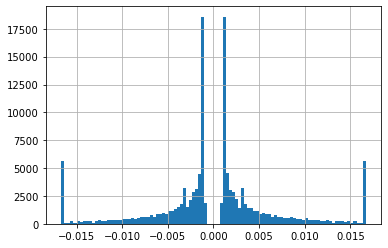

In [13]:
y = (-1)**df["win_target"]
# restrict btw 1 and 25 minutes (length of a title fight)
# short fight times -> big outliers
clipped_time_dur = df["fight_time"].clip(60, (5*5*60))
df["signed_inverse_fight_time"] = y / clipped_time_dur
df["signed_inverse_sqrt_fight_time"] = y / np.sqrt(clipped_time_dur)
df["signed_inverse_log_fight_time"] = y / np.log(clipped_time_dur)

df["signed_inverse_fight_time"].hist(bins=100)

In [22]:
from model.mma_features import RealEloWrapper

real_elo_target_cols = [
#     "fighter_result_time_left", 
#     "ml_logit_mvmt",
    # "ordinal_fighter_result",
    # "submission_fighter_result",
    # "tko_ko_fighter_result",
    # "decision_fighter_result",
    "finish_fighter_result",
    # "signed_inverse_fight_time",
    # "signed_inverse_sqrt_fight_time",
    # "signed_inverse_log_fight_time",
]
diff_elo_target_cols = [
]

binary_elo_target_cols = ["win_target", "win_target_finish"]

elo_alphas = {
    col: real_elo_alpha 
    for col in (real_elo_target_cols + diff_elo_target_cols)
}
# elo_alphas["ml_logit_mvmt"] = 0.225

real_ew = RealEloWrapper(elo_alphas=elo_alphas)
real_elo_feat_df = real_ew.fit_transform_all(df)
print(real_elo_feat_df.shape)
real_elo_feat_df.head()

elo_alphas = {
    col: bin_elo_alpha for col in binary_elo_target_cols
}
bin_ew = BinaryEloWrapper(elo_alphas=elo_alphas)
bin_elo_feat_df = bin_ew.fit_transform_all(df)
print(bin_elo_feat_df.shape)
bin_elo_feat_df.head()
# feat_ml_df["log_height_diff"] = np.log(feat_ml_df["imp_height"]) - np.log(feat_ml_df["imp_height_opp"])
# feat_ml_df["log_age_diff"] = np.log(feat_ml_df["age"]) - np.log(feat_ml_df["age_opp"])
# feat_ml_df["log_reach_diff"] = np.log(feat_ml_df["imp_reach"]) - np.log(feat_ml_df["imp_reach_opp"])
# feat_ml_df["log_reach_diff"] = feat_ml_df["log_reach_diff"].fillna(0)

getting elo features for finish_fighter_result


100%|██████████| 66238/66238 [00:22<00:00, 2988.55it/s]
/Users/john/play/sports/model/mma_elo_model.py:80: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.useless_fighter_ids = pd.Series(sorted(useless_fighter_ids))
100%|██████████| 30660/30660 [12:04<00:00, 42.30it/s]


(132600, 4)
getting elo features for win_target


100%|██████████| 66300/66300 [00:22<00:00, 2890.34it/s]


getting elo features for win_target_finish


100%|██████████| 66300/66300 [00:22<00:00, 2891.83it/s]


(132600, 7)


,FighterID_espn,OpponentID_espn,fight_id,pred_win_target,pred_win_target_logit,pred_win_target_finish,pred_win_target_finish_logit
0,2558095,2354059,1991-09-26_2354059_2558095,0.500000,0.0000,0.500000,0.0000
1,2354119,2501396,1992-01-01_2354119_2501396,0.500000,0.0000,0.500000,0.0000
2,3107994,2354132,1993-08-29_2354132_3107994,0.500000,0.0000,0.500000,0.0000
3,2335653,2557846,1993-09-21_2335653_2557846,0.500000,0.0000,0.500000,0.0000
4,2431322,2335653,1993-10-14_2335653_2431322,0.471905,-0.1125,0.471905,-0.1125


In [23]:
elo_feat_df = df.merge(
    pca_elo_feat_df, 
    how="left", 
    on=["FighterID_espn", "OpponentID_espn", "fight_id"]
).merge(
    real_elo_feat_df,
    how="left",
    on=["FighterID_espn", "OpponentID_espn", "fight_id"]
).merge(
    bin_elo_feat_df,
    how="left",
    on=["FighterID_espn", "OpponentID_espn", "fight_id"]
)
print(elo_feat_df.shape)

(132600, 266)


In [24]:
# yup, still 2 rows per fight_id
elo_feat_df["fight_id"].value_counts()

1991-09-26_2354059_2558095    2
2016-05-12_5088886_5094831    2
2016-05-07_3095234_4043752    2
2016-05-07_4357555_4357565    2
2016-05-07_3154908_3945903    2
                             ..
2011-06-29_3032930_3039197    2
2011-06-30_3128086_4043049    2
2011-06-30_3050600_3070986    2
2011-06-30_3092778_3101066    2
2023-05-13_2500946_3088232    2
Name: fight_id, Length: 66300, dtype: int64

In [25]:
real_elo_feat_df.head()

,FighterID_espn,OpponentID_espn,fight_id,pred_finish_fighter_result
0,2558095,2354059,1991-09-26_2354059_2558095,0.000000
1,2354119,2501396,1992-01-01_2354119_2501396,0.000000
2,3107994,2354132,1993-08-29_2354132_3107994,-0.225000
3,2335653,2557846,1993-09-21_2335653_2557846,0.000000
4,2431322,2335653,1993-10-14_2335653_2431322,-0.534516


# Simpler features

In [26]:
from model.mma_elo_model import unknown_fighter_id
from tqdm import tqdm


def get_simple_features(df):
    # simple things that i needn't get from the fighter stats page
    # eg number of fights, t_since_last_fight
    df = df.assign(
        is_ufc=df["Event"].fillna("").str.contains("UFC"),
        Date=pd.to_datetime(df["Date"]),
    )
    df = df.sort_values("Date")
    ### Rolling features over fighter careers
    # 1. initialize counters, where the index is the fighter id
    fighters = set(df["FighterID_espn"]) | set(df["OpponentID_espn"])
    total_fight_counter = pd.Series(0, index=sorted(fighters))
    total_ufc_fight_counter = pd.Series(0, index=sorted(fighters))
    last_fight_counter = pd.Series(pd.to_datetime("1900-01-01"), index=sorted(fighters))
    # arbitrary date to start with - like starting with np.inf
    first_fight_dt_map = pd.Series(pd.to_datetime("2100-01-01"), index=sorted(fighters))
    feat_df_list = [] # concat this at the end
    # 2. loop over the fights, updating the counters
    for curr_dt, grp in tqdm(df.groupby("Date")):
        fid_vec = grp["FighterID_espn"]
        oid_vec = grp["OpponentID_espn"]
        is_ufc = grp["is_ufc"]
        first_fight_dt_map[fid_vec] = np.minimum(pd.Series(curr_dt, index=fid_vec), 
                                                    first_fight_dt_map[fid_vec])
        first_fight_dt_map[oid_vec] = np.minimum(pd.Series(curr_dt, index=oid_vec), 
                                                    first_fight_dt_map[oid_vec])
        curr_feat_df = pd.DataFrame({
            "FighterID_espn":fid_vec,
            "OpponentID_espn":oid_vec,
            "Date":grp["Date"],
            "total_fights":fid_vec.map(total_fight_counter),
            "total_ufc_fights":fid_vec.map(total_ufc_fight_counter),
            "t_since_last_fight":(curr_dt - fid_vec.map(last_fight_counter)).dt.days,
            # "t_since_first_fight":(curr_dt - fid_vec.map(first_fight_dt_map)).dt.days,
            "total_fights_opp":oid_vec.map(total_fight_counter),
            "total_ufc_fights_opp":oid_vec.map(total_ufc_fight_counter),
            "t_since_last_fight_opp":(curr_dt - oid_vec.map(last_fight_counter)).dt.days,
            # "t_since_first_fight_opp":(curr_dt - oid_vec.map(first_fight_dt_map)).dt.days,
        })
        feat_df_list.append(curr_feat_df)
        # 2.1. add complement features
        curr_feat_df_complement = pd.DataFrame({
            "FighterID_espn":oid_vec,
            "OpponentID_espn":fid_vec,
            "Date":grp["Date"],
        })
        for col in ["total_fights", "total_ufc_fights", "t_since_last_fight",
                    # "t_since_first_fight"
                    ]:
            curr_feat_df_complement[col] = curr_feat_df[col + "_opp"]
            curr_feat_df_complement[col + "_opp"] = curr_feat_df[col]
        feat_df_list.append(curr_feat_df_complement)
        # 2.2. update counters
        # if somehow this guy takes multiple fights in the same day,
        # just count it as one fight. 
        total_fight_counter[fid_vec] += 1
        total_fight_counter[oid_vec] += 1
        last_fight_counter[fid_vec] = curr_dt
        last_fight_counter[oid_vec] = curr_dt
        ufc_grp = grp.loc[is_ufc]
        total_ufc_fight_counter[ufc_grp["FighterID_espn"]] += 1
        total_ufc_fight_counter[ufc_grp["OpponentID_espn"]] += 1
        # make sure unknown_fighter_id stays unknown!
        total_fight_counter[unknown_fighter_id] = 0
        total_ufc_fight_counter[unknown_fighter_id] = 0
        last_fight_counter[unknown_fighter_id] = pd.to_datetime("1900-01-01")
        first_fight_dt_map[unknown_fighter_id] = curr_dt
    feat_df = pd.concat(feat_df_list)
    # cap t_since_last_fight, which can go really long
    # note that because last_fight_counter is initialized to a really early date,
    # this will handle the case where total_fights=0
    feat_df["t_since_last_fight"] = np.minimum(2*365, feat_df["t_since_last_fight"])
    feat_df["t_since_last_fight_opp"] = np.minimum(2*365, feat_df["t_since_last_fight_opp"])
    # 3. compute diffs
    feat_df["t_since_last_fight_diff"] = (feat_df["t_since_last_fight"] - 
                                            feat_df["t_since_last_fight_opp"])
    feat_df["t_since_last_fight_log_diff"] = (np.log(feat_df["t_since_last_fight"]) - 
                                                np.log(feat_df["t_since_last_fight_opp"]))
    feat_df["total_fights_diff"] = (feat_df["total_fights"] - 
                                    feat_df["total_fights_opp"])
    feat_df["total_fights_sqrt_diff"] = (np.sqrt(feat_df["total_fights"]) - 
                                        np.sqrt(feat_df["total_fights_opp"]))
    feat_df["total_ufc_fights_diff"] = (feat_df["total_ufc_fights"] - 
                                        feat_df["total_ufc_fights_opp"])
    feat_df["total_ufc_fights_sqrt_diff"] = (np.sqrt(feat_df["total_ufc_fights"]) - 
                                                np.sqrt(feat_df["total_ufc_fights_opp"]))
    return feat_df

simple_feat_df = get_simple_features(elo_feat_df)
print(simple_feat_df.shape, elo_feat_df.shape)

100%|██████████| 5182/5182 [00:45<00:00, 114.03it/s]


(265200, 15) (132600, 266)


In [27]:
feat_ml_df = elo_feat_df.merge(
    simple_feat_df, 
    how="left",
    on=["FighterID_espn", "OpponentID_espn", "Date"]
)

feat_ml_df["age_diff"] = (feat_ml_df["DOB"] - feat_ml_df["DOB_opp"]).dt.days / 365
feat_ml_df["age_diff"] = feat_ml_df["age_diff"].fillna(0)

feat_ml_df["log_reach_diff"] = (
    np.log(feat_ml_df["ReachInches"]) - np.log(feat_ml_df["ReachInches_opp"])
).fillna(0)
feat_ml_df["weight_diff"] = (
    feat_ml_df["min_weight"] - feat_ml_df["min_weight_opp"]
).fillna(0)
feat_ml_df["height_diff"] = (
    feat_ml_df["HeightInches"] - feat_ml_df["HeightInches_opp"]
).fillna(0)

feat_ml_df["t_since_first_fight_diff"] = (
    feat_ml_df["t_since_first_fight"] - feat_ml_df["t_since_first_fight_opp"]
).fillna(0)
feat_ml_df["log_t_since_first_fight_diff"] = (
    np.log(1 + feat_ml_df["t_since_first_fight"]) - 
    np.log(1 + feat_ml_df["t_since_first_fight_opp"])
).fillna(0)

feat_ml_df["log_t_since_prev_fight_diff"] = (
    np.log(1 + feat_ml_df["t_since_prev_fight"]) -
    np.log(1 + feat_ml_df["t_since_prev_fight_opp"])
).fillna(0)

real_elo_target_cols = [
#     "fighter_result_time_left", 
#     "ml_logit_mvmt",
#     "ordinal_fighter_result",
#     "submission_fighter_result",
#     "tko_ko_fighter_result",
#     "decision_fighter_result",
    # "signed_inverse_fight_time",
    # "finish_fighter_result",
    # *[col for col in stat_pca_df.columns 
    #   if col not in ["FighterID_espn", "OpponentID_espn", "Date"]],
]

feat_cols = [
    *[f"pred_PC_{i}" for i in range(n_pca)],

    *["pred_"+c for c in [*diff_elo_target_cols, 
                               *real_elo_target_cols, 
                               *binary_elo_target_cols]],
    
    # "t_since_last_fight_log_diff", 
#     "fights_per_day_diff",
#     "t_since_last_fight_diff",
#     "total_fights_sqrt_diff", 
#     "total_ufc_fights_diff",
    
    "age_diff", 
#     "log_age_diff",
#     "reach_diff", 
    "log_reach_diff",
    "weight_diff", 
#     "log_weight_diff",
    "height_diff",
#     "log_height_diff",
#     "ml_logit_mvmt",
    "log_t_since_prev_fight_diff",
    "log_t_since_first_fight_diff",
    "total_fights_diff",
#     "quad_log_t_since_first_fight_diff",
]

# new_feat_cols = [*feat_cols, "ml_logit"]
feat_cols

['pred_PC_0',
 'pred_win_target',
 'pred_win_target_finish',
 'age_diff',
 'log_reach_diff',
 'weight_diff',
 'height_diff',
 'log_t_since_prev_fight_diff',
 'log_t_since_first_fight_diff',
 'total_fights_diff']

In [28]:
# checking to see how much data we have for each feature
feat_ml_df[feat_cols].notnull().sum()

pred_PC_0                       132608
pred_win_target                 265200
pred_win_target_finish          265200
age_diff                        265200
log_reach_diff                  265200
weight_diff                     265200
height_diff                     265200
log_t_since_prev_fight_diff     265200
log_t_since_first_fight_diff    265200
total_fights_diff               265200
dtype: int64

In [29]:
feat_ml_df = feat_ml_df.drop_duplicates(subset=["fight_id"])
print(feat_ml_df[feat_cols].notnull().sum())
feat_ml_df.shape

pred_PC_0                       33152
pred_win_target                 66300
pred_win_target_finish          66300
age_diff                        66300
log_reach_diff                  66300
weight_diff                     66300
height_diff                     66300
log_t_since_prev_fight_diff     66300
log_t_since_first_fight_diff    66300
total_fights_diff               66300
dtype: int64


(66300, 285)

# Model evaluation - opening line

In [ ]:
p_fighter_implied_col = "p_fighter_open_implied"

In [ ]:
from model.mma_log_reg_stan import SimpleSymmetricModel

mod = SimpleSymmetricModel(
    feat_cols=feat_cols, target_col="win_target", 
    p_fighter_implied_col=p_fighter_implied_col,
    beta_prior_std=1.0, mcmc=False
)

In [ ]:
from model_selection.cross_val_pipeline import TimeSeriesCrossVal

tscv = TimeSeriesCrossVal(min_test_date=pd.to_datetime("2021-01-01"), 
                          n_dates_per_fold=1, 
                          p_fighter_implied_col=p_fighter_implied_col)
preds_df = tscv.get_cross_val_preds(
    mod, 
    feat_ml_df.dropna(subset=[
        *feat_cols, "win_target", p_fighter_implied_col,
    ])
)

training on date range: 2007-07-07 2020-12-31
Initial log joint probability = -12013.2
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19       -5893.6   0.000652813      0.251603           1           1       20   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      20       -5893.6   0.000110628     0.0783877       0.864       0.864       21   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
training on date range: 2007-07-07 2021-01-16
Initial log joint probability = -9918.67
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      18      -5901.83    0.00011246      0.073779           1           1       19   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
training on date range: 2007-07-07 2021-01-20
Initial log joint probability =

In [ ]:
mod_pred = preds_df["y_pred"].round()
ml_pred = preds_df[p_fighter_implied_col].round()
print("Model accuracy:     ", (mod_pred == preds_df["win_target"]).mean())
print("Moneyline accuracy: ", (ml_pred == preds_df["win_target"]).mean())

Model accuracy:      0.6853593015446608
Moneyline accuracy:  0.6672263263935527


In [ ]:
from sklearn.metrics import log_loss

xce = log_loss(y_true=preds_df["win_target"], y_pred=preds_df["y_pred"])
xce_ml = log_loss(y_true=preds_df["win_target"], y_pred=preds_df[p_fighter_implied_col])

print(f"model log loss    : {xce}")
print(f"Money ine log loss: {xce_ml}")

model log loss    : 0.5847940575547039
Money ine log loss: 0.6075945678391452


In [ ]:
preds_df["week"] = preds_df["Date"].dt.isocalendar().week

In [ ]:
fighter_ml_col = "FighterOpen"
opponent_ml_col = "OpponentOpen"

overall winnings


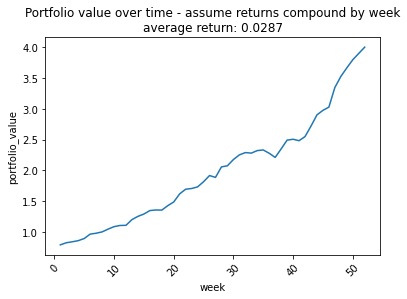

ufc winnings


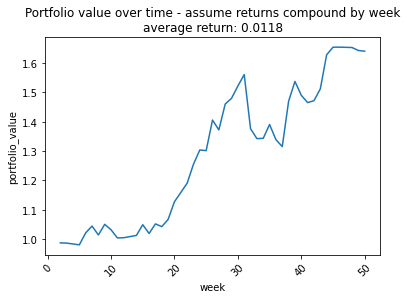

non-ufc winnings


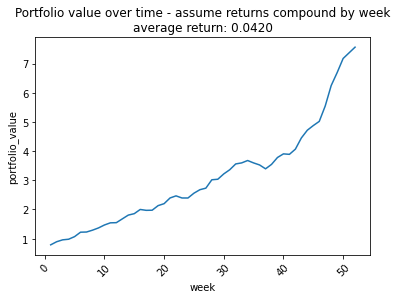

In [ ]:
from model_selection.metrics import MultiKellyPM

kwargs = {
    "max_bankroll_fraction": 1,
    "groupby_col": "week",
    "fighter_ml_col": fighter_ml_col,
    "opponent_ml_col": opponent_ml_col,
}

print("overall winnings")
pm = MultiKellyPM(preds_df, **kwargs)
event_return_df = pm.get_all_returns()
pm.plot_diagnostics(event_return_df, x_col="week")

print("ufc winnings")
pm = MultiKellyPM(preds_df.query("is_ufc == 1"), **kwargs)
event_return_df = pm.get_all_returns()
pm.plot_diagnostics(event_return_df, x_col="week")

print("non-ufc winnings")
pm = MultiKellyPM(preds_df.query("is_ufc == 0"), **kwargs)
event_return_df = pm.get_all_returns()
pm.plot_diagnostics(event_return_df, x_col="week")

# Model evaluation - BetMGM, DraftKings, BetFair

In [ ]:
close_df = base_db_interface.read("clean_bfo_close_data")
# double the data
fighter_cols = [c for c in close_df.columns if c.endswith("_fighter")]
opponent_cols = [c[:-len("_fighter")] + "_opponent" for c in fighter_cols]
for col in fighter_cols + opponent_cols:
    close_df[col] = close_df[col].str.replace("▲", "")\
        .str.replace("▼", "")\
        .astype(float)
    
close_df_complement = close_df.rename(columns={
    "FighterID": "OpponentID",
    "OpponentID": "FighterID",
    **{f: o for f, o in zip(fighter_cols, opponent_cols)},
    **{o: f for f, o in zip(fighter_cols, opponent_cols)},
})
close_df = pd.concat([close_df, close_df_complement], axis=0)\
    .drop_duplicates(subset=["FighterID", "OpponentID", "EventHref"])\
    .dropna(subset=["FighterID", "OpponentID", "EventHref"])\
    .rename(columns={"FighterID": "FighterID_bfo", "OpponentID": "OpponentID_bfo"})\
    .drop(columns=["FighterName", "OpponentName"])\
    .reset_index(drop=True)

print(close_df.shape)
close_df.isnull().mean()

(16196, 26)


match_id               0.000000
EventHref              0.000000
DraftKings_fighter     0.764263
BetMGM_fighter         0.795258
Caesars_fighter        0.788837
BetRivers_fighter      0.865275
FanDuel_fighter        0.766980
PointsBet_fighter      0.903680
Unibet_fighter         0.815140
BetWay_fighter         0.660040
5D_fighter             0.083107
Ref_fighter            0.018400
FighterID_bfo          0.000000
Bet365_fighter         0.904791
DraftKings_opponent    0.764263
BetMGM_opponent        0.795258
Caesars_opponent       0.788837
BetRivers_opponent     0.865275
FanDuel_opponent       0.766980
PointsBet_opponent     0.903680
Unibet_opponent        0.815140
BetWay_opponent        0.660040
5D_opponent            0.083107
Ref_opponent           0.018400
OpponentID_bfo         0.000000
Bet365_opponent        0.904791
dtype: float64

In [ ]:
preds_df["FighterID_bfo"]

61298        Carlos-Felipe-7484
61299             Wu-Yanan-8993
61300         David-Zawada-5347
61301      Dusko-Todorovic-9397
61302      Joaquin-Buckley-6458
                  ...          
66231         Randi-Field-12666
66232    Christian-Edwards-8986
66233        Sara-Collins-15532
66234      Adam-Piccolotti-5863
66235    Brandon-Carrillo-15533
Name: FighterID_bfo, Length: 2978, dtype: object

In [ ]:
aug_preds_df = preds_df.merge(
    close_df,
    how="left",
    on=["FighterID_bfo", "OpponentID_bfo", "EventHref"],
)
aug_preds_df.isnull().mean()

fight_id           0.000000
Date               0.000000
FighterResult      0.000000
Decision           0.000000
Rnd                0.000000
                     ...   
Unibet_opponent    0.574547
BetWay_opponent    0.268972
5D_opponent        0.416387
Ref_opponent       0.269308
Bet365_opponent    0.801545
Length: 309, dtype: float64

In [ ]:
close_df[["DraftKings_fighter", "BetMGM_fighter"]]

,DraftKings_fighter,BetMGM_fighter
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
16191,-365.0,-450.0
16192,NaN,-450.0
16193,-435.0,-450.0
16194,575.0,600.0


In [ ]:
preds_df[fighter_ml_col]

61298   -115.0
61299   -240.0
61300    180.0
61301   -150.0
61302   -275.0
         ...  
66231   -300.0
66232   -500.0
66233   -105.0
66234   -150.0
66235    500.0
Name: FighterOpen, Length: 2978, dtype: float64

overall winnings


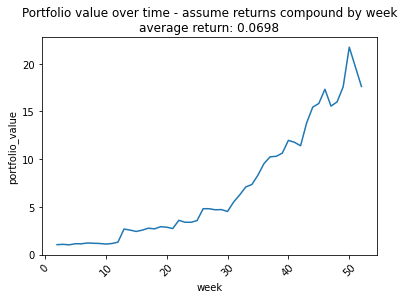

ufc winnings


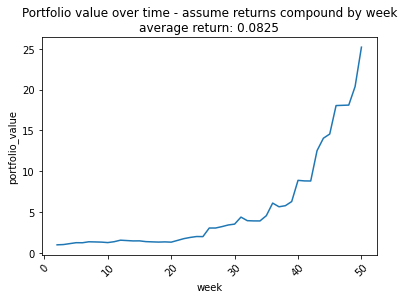

non-ufc winnings


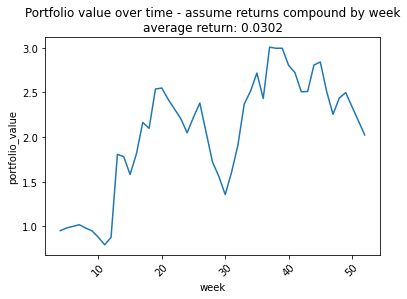

In [ ]:
market = "DraftKings"
# market = "BetMGM"

kwargs = {
    "max_bankroll_fraction": 1,
    "groupby_col": "week",
    "fighter_ml_col": f"{market}_fighter",
    "opponent_ml_col": f"{market}_opponent",
}

temp_preds_df = aug_preds_df.dropna(subset=[
    f"{market}_fighter", f"{market}_opponent"
])
temp_preds_df

print("overall winnings")
pm = MultiKellyPM(temp_preds_df, **kwargs)
event_return_df = pm.get_all_returns()
pm.plot_diagnostics(event_return_df, x_col="week")

print("ufc winnings")
pm = MultiKellyPM(temp_preds_df.query("is_ufc == 1"), **kwargs)
event_return_df = pm.get_all_returns()
pm.plot_diagnostics(event_return_df, x_col="week")

print("non-ufc winnings")
pm = MultiKellyPM(temp_preds_df.query("is_ufc == 0"), **kwargs)
event_return_df = pm.get_all_returns()
pm.plot_diagnostics(event_return_df, x_col="week")

# Predictions for upcoming fights

In [ ]:
mod = SimpleSymmetricModel(
    feat_cols=feat_cols, target_col="win_target", 
    p_fighter_implied_col=p_fighter_implied_col,
    beta_prior_std=1.0, mcmc=False
)
preds_df = tscv.get_cross_val_preds(
    mod, 
    feat_ml_df.dropna(subset=[
        *feat_cols, "win_target", p_fighter_implied_col,
    ])
)

training on date range: 2007-07-07 2020-12-31
Initial log joint probability = -14725.8
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19       -5893.6   0.000738113      0.414203           1           1       20   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      21       -5893.6   0.000155051     0.0314458           1           1       22   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
training on date range: 2007-07-07 2021-01-16
Initial log joint probability = -12876
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      17      -5901.83    0.00311736     0.0660534           1           1       18   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
training on date range: 2007-07-07 2021-01-20
Initial log joint probability = -

In [ ]:
from wrangle.clean_bfo_data import parse_american_odds

main_card_df = [
    ("Israel Adesanya", "Alex Pereira", "-150", "+130"),
    ("Gilbert Burns", "Jorge Masvidal", "-500", "+400"),
    ("Adrian Yanez", "Rob Font", "-185", "+160"),
    ("Kevin Holland", "Santiago Ponzinibbio", "-200", "+170"),
    ("Christian Rodriguez", "Raul Rosas Jr.", "+210", "-250"),
]
main_card_df = pd.DataFrame(
    main_card_df, 
    columns=["FighterName_ufc", "OpponentName_ufc", 
             "FighterOpen", "OpponentOpen"],
)
main_card_df_complement = main_card_df.rename(columns={
    "FighterName_ufc": "OpponentName_ufc",
    "OpponentName_ufc": "FighterName_ufc",
    "FighterOpen": "OpponentOpen",
    "OpponentOpen": "FighterOpen",
})
main_card_df = pd.concat([
    main_card_df,
    main_card_df_complement,
]).reset_index(drop=True)
main_card_df

,FighterName_ufc,OpponentName_ufc,FighterOpen,OpponentOpen
0,Israel Adesanya,Alex Pereira,-150,+130
1,Gilbert Burns,Jorge Masvidal,-500,+400
2,Adrian Yanez,Rob Font,-185,+160
3,Kevin Holland,Santiago Ponzinibbio,-200,+170
4,Christian Rodriguez,Raul Rosas Jr.,+210,-250
5,Alex Pereira,Israel Adesanya,+130,-150
6,Jorge Masvidal,Gilbert Burns,+400,-500
7,Rob Font,Adrian Yanez,+160,-185
8,Santiago Ponzinibbio,Kevin Holland,+170,-200
9,Raul Rosas Jr.,Christian Rodriguez,-250,+210


In [ ]:
train_df = feat_ml_df.query("is_ufc == 1 & is_upcoming == 0")\
    .dropna(subset=[
        *feat_cols, "win_target", p_fighter_implied_col
    ])
test_df = feat_ml_df.query("is_upcoming == 1 & Date == '2023-04-08'").copy()
test_df = test_df.drop(columns=["FighterOpen", "OpponentOpen"]).merge(
    main_card_df,
    how="inner",
    on=["FighterName_ufc", "OpponentName_ufc"],
)
p_fighter = parse_american_odds(test_df["FighterOpen"])
p_opponent = parse_american_odds(test_df["OpponentOpen"])
test_df["p_fighter_open_implied"] = p_fighter / (p_fighter + p_opponent)
test_df
# test_df[p_fighter_implied_col] = test_df[p_fighter_implied_col].fillna(0.5)
train_df.shape, test_df.shape

((5844, 283), (5, 283))

In [ ]:
test_df[["FighterName_ufc", "OpponentName_ufc"]]

,FighterName_ufc,OpponentName_ufc
0,Israel Adesanya,Alex Pereira
1,Rob Font,Adrian Yanez
2,Gilbert Burns,Jorge Masvidal
3,Santiago Ponzinibbio,Kevin Holland
4,Christian Rodriguez,Raul Rosas Jr.


In [ ]:
bfo_to_ufc_map = base_db_interface.read("bfo_to_ufc_map")
bfo_to_ufc_map

,FighterID_bfo,OpponentID_bfo,Date,FighterID_ufc,OpponentID_ufc
0,A-J-Dobson-10772,Armen-Petrosyan-11514,2022-10-22 00:00:00,009c4420727149ea,369ea36e450ae62a
1,A-J-Fletcher-12271,Themba-Gorimbo-12770,2023-02-18 00:00:00,725b1abc9a39d873,40f3cb27fc7305a1
2,A-J-Fletcher-12271,Ange-Loosa-9074,2022-08-20 00:00:00,725b1abc9a39d873,1497e735d9f2560a
3,A-J-Fletcher-12271,Matthew-Semelsberger-10268,2022-03-12 00:00:00,725b1abc9a39d873,4aa58269d0664b5b
4,A-J-Fletcher-12271,Leonardo-Damiani-10527,2021-08-31 00:00:00,725b1abc9a39d873,acd870570949d8a2
...,...,...,...,...,...
15043,Zubaira-Tukhugov-5054,Renato-Moicano-5598,2016-05-14 00:00:00,aceffa19749c4dc0,b6452706b373eea1
15044,Zubaira-Tukhugov-5054,Phillipe-Nover-985,2015-12-10 00:00:00,aceffa19749c4dc0,64360e618823a8e4
15045,Zubaira-Tukhugov-5054,Ernest-Chavez-4689,2014-10-04 00:00:00,aceffa19749c4dc0,b406da701c479076
15046,Zubaira-Tukhugov-5054,Kevin-Aguilar-2365,2020-02-22 00:00:00,aceffa19749c4dc0,cf946e03ba2e7666


In [ ]:
ufc_df = close_df.query("EventHref == '/events/ufc-287-2760'")
print(ufc_df.shape)
ufc_df = ufc_df.merge(
    bfo_to_ufc_map[["FighterID_bfo", "FighterID_ufc"]].drop_duplicates(), 
    how="left", 
    on=["FighterID_bfo"]
).merge(
    bfo_to_ufc_map[["OpponentID_bfo", "OpponentID_ufc"]].drop_duplicates(),
    how="left",
    on=["OpponentID_bfo"]
)
print(ufc_df.shape)
ufc_df

(24, 26)
(24, 28)


,match_id,EventHref,DraftKings_fighter,BetMGM_fighter,Caesars_fighter,BetRivers_fighter,FanDuel_fighter,PointsBet_fighter,Unibet_fighter,BetWay_fighter,...,FanDuel_opponent,PointsBet_opponent,Unibet_opponent,BetWay_opponent,5D_opponent,Ref_opponent,OpponentID_bfo,Bet365_opponent,FighterID_ufc,OpponentID_ufc
0,0.0,/events/ufc-287-2760,-450.0,-450.0,-475.0,-455.0,-490.0,NaN,NaN,-450.0,...,380.0,NaN,NaN,333.0,NaN,340.0,Jorge-Masvidal-99,350.0,23024fdfc966410a,47b9e0e7703a4868
1,1.0,/events/ufc-287-2760,NaN,-190.0,-180.0,-190.0,-180.0,NaN,-190.0,-188.0,...,152.0,NaN,150.0,150.0,NaN,162.0,Rob-Font-4984,150.0,0232cabbc30a2372,05339613bf8e9808
2,2.0,/events/ufc-287-2760,NaN,-250.0,-260.0,-250.0,-250.0,NaN,-250.0,-250.0,...,205.0,NaN,195.0,200.0,NaN,195.0,Santiago-Ponzinibbio-4415,200.0,3a46b268013afede,6d1bffff14897645
3,3.0,/events/ufc-287-2760,NaN,200.0,220.0,195.0,198.0,NaN,195.0,200.0,...,-240.0,NaN,-250.0,-250.0,NaN,-230.0,Raul-Rosas-Jr-14405,-225.0,NaN,NaN
4,4.0,/events/ufc-287-2760,NaN,120.0,115.0,110.0,108.0,NaN,110.0,100.0,...,-130.0,NaN,-137.0,-125.0,NaN,-141.0,Kelvin-Gastelum-4061,-138.0,5442f1bc4b47eaf3,8c0580d4fff106c1
5,5.0,/events/ufc-287-2760,NaN,-165.0,-170.0,-167.0,-166.0,NaN,-167.0,-163.0,...,140.0,NaN,133.0,130.0,NaN,145.0,Michelle-Waterson-3944,140.0,a3a542074109b347,eb04b9d31e938edb
6,6.0,/events/ufc-287-2760,NaN,160.0,170.0,155.0,168.0,NaN,155.0,160.0,...,-200.0,NaN,-200.0,-200.0,NaN,-185.0,Joe-Pyfer-8530,-188.0,6ac9bc2953c47345,c1085e1701b13eca
7,7.0,/events/ufc-287-2760,NaN,310.0,325.0,325.0,350.0,NaN,325.0,333.0,...,-450.0,NaN,-435.0,-450.0,NaN,-420.0,Karl-Williams-13254,-500.0,01b352b6a9074d5c,d35f734c56a89103
8,8.0,/events/ufc-287-2760,NaN,240.0,235.0,225.0,235.0,NaN,225.0,210.0,...,-290.0,NaN,-295.0,-275.0,NaN,-251.0,Lupita-Godinez-9456,-300.0,98215d037be5bcb7,8e5d953bdb9ae5e7
9,9.0,/events/ufc-287-2760,NaN,-375.0,-360.0,-345.0,-330.0,NaN,-345.0,-350.0,...,265.0,NaN,265.0,260.0,NaN,330.0,Trey-Ogden-5784,275.0,e4a47b07044ddd72,cfc3e7bb44685289


In [ ]:
aug_test_df = test_df.merge(
    ufc_df,
    how="left",
    on=["FighterID_ufc", "OpponentID_ufc"],
)
aug_test_df

,fight_id,Date,FighterResult,Decision,Rnd,Time,Event,OpponentID_espn,FighterID_espn,TSL,...,Caesars_opponent,BetRivers_opponent,FanDuel_opponent,PointsBet_opponent,Unibet_opponent,BetWay_opponent,5D_opponent,Ref_opponent,OpponentID_bfo_y,Bet365_opponent
0,2023-04-08_4285679_4705658,2023-04-08,None,None,-,-,None,4705658,4285679,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-04-08_3090451_3998248,2023-04-08,None,None,-,-,None,3998248,3090451,NaN,...,-180.0,-190.0,-180.0,NaN,-190.0,-188.0,NaN,-187.0,Adrian-Yanez-4952,-175.0
2,2023-04-08_2500857_3090197,2023-04-08,None,None,-,-,None,2500857,3090197,NaN,...,350.0,350.0,380.0,NaN,NaN,333.0,NaN,340.0,Jorge-Masvidal-99,350.0
3,2023-04-08_3043484_3943695,2023-04-08,None,None,-,-,None,3943695,3043484,NaN,...,-260.0,-250.0,-250.0,NaN,-250.0,-250.0,NaN,-230.0,Kevin-Holland-5910,-250.0
4,2023-04-08_4875511_5088844,2023-04-08,None,None,-,-,None,5088844,4875511,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# aug_test_df["p_fighter_open_implied"]# = aug_test_df["p_fighter_open_implied"].fillna(0.5)
aug_test_df.columns[aug_test_df.columns.str.contains("p_fighter_open_implied")]

Index(['p_fighter_open_implied'], dtype='object')

In [ ]:
mod = SimpleSymmetricModel(
    feat_cols=feat_cols, target_col="win_target", 
    p_fighter_implied_col=p_fighter_implied_col,
    beta_prior_std=1.0, mcmc=False
)

y_pred = mod.fit_predict(train_df, aug_test_df, feat_cols)
y_pred

Initial log joint probability = -9817.81


array([0.65594788, 0.42042161, 0.79439702, 0.3938325 , 0.32033642])

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -3609.45    0.00147672       1.59535      0.5915      0.5915       21   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      23      -3609.45   0.000155556       0.10173           1           1       25   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [ ]:
from scipy.special import logit, expit
preds_df = aug_test_df.assign(
    y_pred = y_pred,
    # bet_dir = logit(y_pred) - logit(0.5)
)
preds_df[[
    "FighterName_ufc", "OpponentName_ufc", 
    p_fighter_implied_col, 
    "y_pred", "Date",
    # "DraftKings_fighter", "DraftKings_opponent",
    "BetMGM_fighter", "BetMGM_opponent",
    "Caesars_fighter", "Caesars_opponent",
    "FanDuel_fighter", "FanDuel_opponent",
]]

for col in [
        "BetMGM_fighter", "BetMGM_opponent",
    "Caesars_fighter", "Caesars_opponent",
    "FanDuel_fighter", "FanDuel_opponent",
    # "FighterOpen", "Opponent"
    ]:
    preds_df[col] = preds_df[col].astype(float)
preds_df

,fight_id,Date,FighterResult,Decision,Rnd,Time,Event,OpponentID_espn,FighterID_espn,TSL,...,BetRivers_opponent,FanDuel_opponent,PointsBet_opponent,Unibet_opponent,BetWay_opponent,5D_opponent,Ref_opponent,OpponentID_bfo_y,Bet365_opponent,y_pred
0,2023-04-08_4285679_4705658,2023-04-08,None,None,-,-,None,4705658,4285679,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.655948
1,2023-04-08_3090451_3998248,2023-04-08,None,None,-,-,None,3998248,3090451,NaN,...,-190.0,-180.0,NaN,-190.0,-188.0,NaN,-187.0,Adrian-Yanez-4952,-175.0,0.420422
2,2023-04-08_2500857_3090197,2023-04-08,None,None,-,-,None,2500857,3090197,NaN,...,350.0,380.0,NaN,NaN,333.0,NaN,340.0,Jorge-Masvidal-99,350.0,0.794397
3,2023-04-08_3043484_3943695,2023-04-08,None,None,-,-,None,3943695,3043484,NaN,...,-250.0,-250.0,NaN,-250.0,-250.0,NaN,-230.0,Kevin-Holland-5910,-250.0,0.393832
4,2023-04-08_4875511_5088844,2023-04-08,None,None,-,-,None,5088844,4875511,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.320336


In [ ]:
preds_df[["FighterName_ufc", "OpponentName_ufc", "y_pred", p_fighter_implied_col, "Date"]]

,FighterName_ufc,OpponentName_ufc,y_pred,p_fighter_open_implied,Date
0,Israel Adesanya,Alex Pereira,0.655948,0.579832,2023-04-08
1,Rob Font,Adrian Yanez,0.420422,0.372063,2023-04-08
2,Gilbert Burns,Jorge Masvidal,0.794397,0.806452,2023-04-08
3,Santiago Ponzinibbio,Kevin Holland,0.393832,0.357143,2023-04-08
4,Christian Rodriguez,Raul Rosas Jr.,0.320336,0.311111,2023-04-08


In [ ]:
from model_selection.metrics import MultiKellyPM

pm = MultiKellyPM(preds_df,
                  fighter_ml_col="FanDuel_fighter",
                    opponent_ml_col="FanDuel_opponent",
                  parse_ml=True)
pm.get_portfolio_weights()

,fight_id,Date,y_pred,FighterID_espn,OpponentID_espn,fighter_payout,opponent_payout,fighter_bet,opponent_bet
0,2023-04-08_4285679_4705658,2023-04-08,0.655948,4285679,4705658,NaN,NaN,0.000000,0.0
1,2023-04-08_3090451_3998248,2023-04-08,0.420422,3090451,3998248,1.520000,0.555556,0.019560,0.0
2,2023-04-08_2500857_3090197,2023-04-08,0.794397,3090197,2500857,0.204082,3.800000,0.000000,0.0
3,2023-04-08_3043484_3943695,2023-04-08,0.393832,3043484,3943695,2.050000,0.400000,0.049071,0.0
4,2023-04-08_4875511_5088844,2023-04-08,0.320336,4875511,5088844,NaN,NaN,0.000000,0.0
